# Implementando uma MLP básica com Grid Search para escolher melhor os parâmetros

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 100

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.style.use('dark_background')

### 1.2 Bibliotecas para MLP

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from tensorboard.plugins.hparams import api as hp

In [18]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

### 1.3 Bibliotecas dos sistemas caóticos

In [3]:
import sys 
sys.path.insert(0, '../../../scripts')

import timeseries as times
import lorenzsystem as lorz
import logisticmap as logmap
import henonmap as henon
import mackeyglassequations as mackgl

## 2. Gerando a série temporal do mapa logístico

Os valores para os parâmetros das equações serão os "básicos" apresentados no *paper* original. Utilizaremos  $\tau = 22$, o que faz com que o sistemas esteja em caos.

In [4]:
x_inicial = 0.5
n_inicial = 0
n_iteracoes = 1000
r=3.86
estados = np.array([x_inicial, n_inicial])

In [5]:
mapa = logmap.MapaLogistico(estado_inicial=estados)

In [6]:
for n in range(0, n_iteracoes):
    mapa.iterar()
    estados = np.vstack((estados, mapa.ler_estado()))

In [7]:
x = estados[:, 0]
n = estados[:, 1]

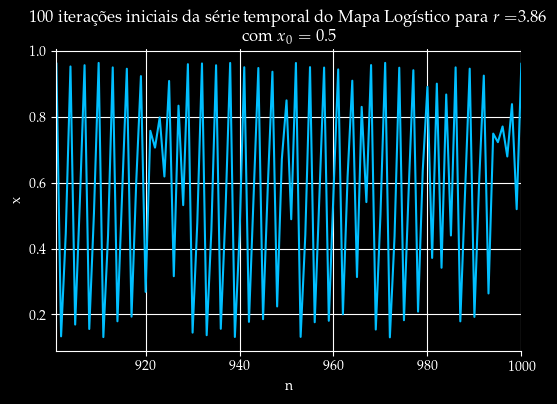

In [90]:
fig, ax = plt.subplots()
ax.plot(n, x, color='DeepSkyBlue')

ax.set_title("100 iterações iniciais da série temporal do Mapa Logístico para $r = $" + str(r) + " \n com $x_{0} =$ " + str(x[0]))
ax.set_ylabel('x')
ax.set_xlabel('n')
ax.set_xlim(0,100)
    
ax.grid(True)
sns.despine()

plt.show()

### 2.1 Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [25]:
K = 4
L = 3
tam_teste = 0.1

In [23]:
serie_temporal = times.SerieTemporal(x, K=K, L=L)

In [24]:
serie_temporal.criar_matrizes()

In [26]:
X_treino, X_teste, y_treino, y_teste = serie_temporal.dividir_treino_teste(tam_teste)

In [47]:
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=tam_teste, random_state=1)

## 3. Definindo o modelo para a MLP

### 3.1 Definindo parâmetros que não serão definidos pelo Grid Search

In [65]:
loss = "mean_squared_error"
optimizer = "Nadam"
metrics = [tf.keras.metrics.RootMeanSquaredError()]

### 3.2 Definindo as primeiras métricas a serem avaliadas pelo Grid Search

Primeiro, avaliaremos o impacto do *batch size*, da função de ativação e da inicialização dos neurônios, e a taxa de aprendizado. O número de épocas será determinado quando formos treinar a rede, através do *early stopping*.

### 3.2 Definindo a classe da MLP

In [66]:
def criar_modelo_gs_1():
    
    model = keras.Sequential()
    model.add(keras.layers.Dense(K, input_dim=K, name="camda_de_entrada", activation = 'linear'))
    model.add(keras.layers.Dense(30, input_dim=8, activation='relu', name="camada_intermediaria"))
    model.add(keras.layers.Dense(1, activation='linear', name="camada_de_saida"))
    
    model.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = metrics)
    
    return model

In [67]:
modelo = criar_modelo_gs_1()

In [68]:
modelo.build()

In [69]:
modelo.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camda_de_entrada (Dense)     (None, 4)                 20        
_________________________________________________________________
camada_intermediaria (Dense) (None, 30)                150       
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 31        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [70]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)

In [71]:
batch_size = 32

In [72]:
history = modelo.fit(X_treino, y_treino, epochs=100,
                            callbacks=early_stopping, validation_data=(X_val, y_val),
                            batch_size=batch_size)
treinamento = pd.DataFrame(history.history)

Epoch 1/100
26/26 [==============================] - 0s 5ms/step - loss: 0.1680 - root_mean_squared_error: 0.4096 - val_loss: 0.1006 - val_root_mean_squared_error: 0.3172
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 0.1069 - root_mean_squared_error: 0.3270 - val_loss: 0.0837 - val_root_mean_squared_error: 0.2894
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0904 - root_mean_squared_error: 0.3006 - val_loss: 0.0706 - val_root_mean_squared_error: 0.2657
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0731 - root_mean_squared_error: 0.2703 - val_loss: 0.0603 - val_root_mean_squared_error: 0.2455
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0653 - root_mean_squared_error: 0.2555 - val_loss: 0.0555 - val_root_mean_squared_error: 0.2355
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0612 - root_mean_squared_error: 0.2470 - val_loss: 0.0535 - val_root_m

## Teste com o melhor modelo

In [75]:
y_pred = modelo.predict(X_teste)

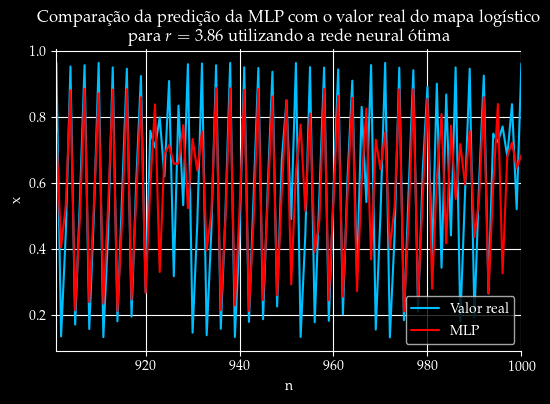

In [100]:
fig, ax = plt.subplots()
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_teste, color='DeepSkyBlue', label='Valor real')
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_pred, color='Red', label='MLP')

ax.set_title("Comparação da predição da MLP com o valor real do mapa logístico \npara $r = $ " + str(r) + " utilizando a rede neural ótima")
ax.set_ylabel('x')
ax.set_xlabel('n')
ax.set_xlim(901, 1000)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()